<a href="https://colab.research.google.com/github/methrex/COT5600/blob/master/hw_3/COT5600_HW3_problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
# -- Importing standard Qiskit libraries and configuring account
# -- Importing pi and NumPy
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from math import pi
import numpy as np

# -- Loading your IBM Q account(s)
provider = IBMQ.load_account()

Credentials are already in use. The existing account in the session will be replaced.


In [0]:
# -- Define the inverse QFT.
# -- Qiskit qubits are ordered differently than how we've seen in class. I forgot about this and
#    had to take a look at the documentation to see what I was doing wrong and an example of how to 
#    implement it. For the three-qubit example, we only need to switch the first and last qubits.

def QFT_dag(q_circ,num_q):
    # -- swap qubits to be in "standard" (?) order
    for q in range(num_q//2):
        q_circ.swap(q, num_q - q - 1)
        
    # -- iterate over the control qubits 
    for q in range(num_q):
        
        # -- apply c-R_dag gates 
        for p in range(q):
            q_circ.cu3( 0,-pi * 2**(p-q),0,p,q )
            
        # -- apply a final H gate to this qubit
        q_circ.h(q)

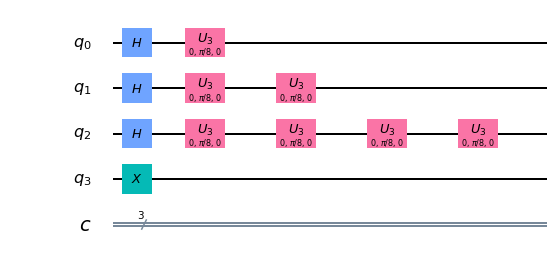

In [0]:
# -- initialize qubits. 3 control + 1 target, 3 classical
num_q = 3
q_phase = QuantumCircuit(num_q+1,num_q)

# -- Place the first gates down. 
#    Hadarmard: |0> --> |+>
#    X:         |0> --> |1>

# -- Hadamard gates on control qubits
for qubit in range(num_q):
    q_phase.h(qubit)

# -- X gate on target qubit
q_phase.x(num_q)

# -- let's pick a phase in [0,1) to give to our qubits
phase = 1/16  # <---------------------------------------  [change this for different phases]
angle = 2 * pi * phase  #pi/2

# -- number of times to apply the U gates for different qubits
powers_2 = 2**np.arange(num_q)

# -- add the gates to the circuit
for control in range(num_q):
    for times in range(powers_2[control]):
        q_phase.u3(0,angle,0,control)
        
# -- check out our new circuit to make sure everything is ok
q_phase.draw()

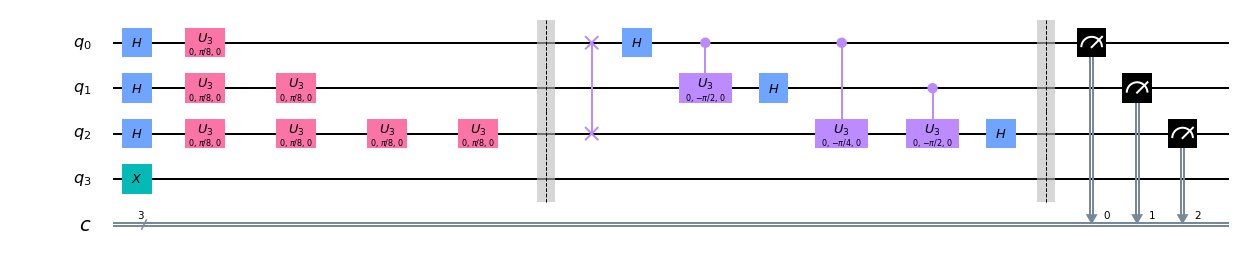

In [0]:
# -- apply a barrier, then apply our inverse QFT operation, then apply a barrier
q_phase.barrier()
QFT_dag(q_phase,num_q)
q_phase.barrier()

# -- make a measurement on each control qubit
for k in range(num_q):
    q_phase.measure(k,k)
    
# -- look at our final circuit
q_phase.draw()

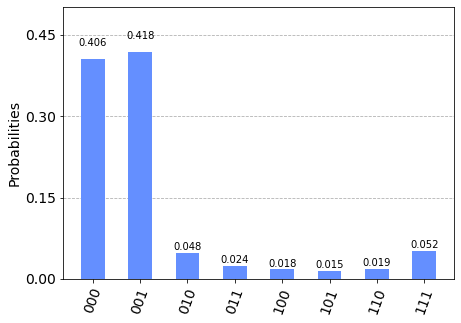

In [0]:
# -- get a backend
backend = Aer.get_backend('qasm_simulator')

# -- number of shots
shots   = 8192

# -- grab results
results = execute(q_phase,backend=backend,shots=shots).result()
counts  = results.get_counts()

# -- plot the results!
plot_histogram(counts)

In [0]:
# -- We don't have the required precision to hit our phase of 1/16. The probability is highest at
#    |000> and |001>, which correspond to 0/8 and 1/8. Our phase, 1/16, is exactly in between these two
#    0/16 < 1/16 < 2/16=1/8 ... or so I think (: 

# -- Running this with a phase = 0/8, 1/8, 2/8, ..., or 7/8 will give a probability of 1.000 for state that
#    corresponds to the binary expression of that phase*8. Of course, 8/8 = 1 wraps around to 0/8 = 0. 